# Beijing Air Quality Forecasting Starter Notebook

In [31]:
pip install tensorflow



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam




In [33]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/workspaces/Time-Series-Forecasting/data/train.csv')
test = pd.read_csv('/workspaces/Time-Series-Forecasting/data/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [34]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()


Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [35]:

# Summarize the train and test data
print("Summary of Train Data:")
print(train.describe())

print("\nSummary of Test Data:")
print(test.describe())
     

Summary of Train Data:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.087278      1.0

In [36]:
# Data colunms
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


In [37]:
#Check the mode of the target column and count
mode_value = train['pm2.5'].mode()[0]
print(mode_value)

mode_count = train['pm2.5'].value_counts()
print(mode_count)


16.0
pm2.5
16.0     462
13.0     407
11.0     402
12.0     386
17.0     385
        ... 
478.0      1
524.0      1
491.0      1
541.0      1
517.0      1
Name: count, Length: 563, dtype: int64


pm2.5    1921
dtype: int64


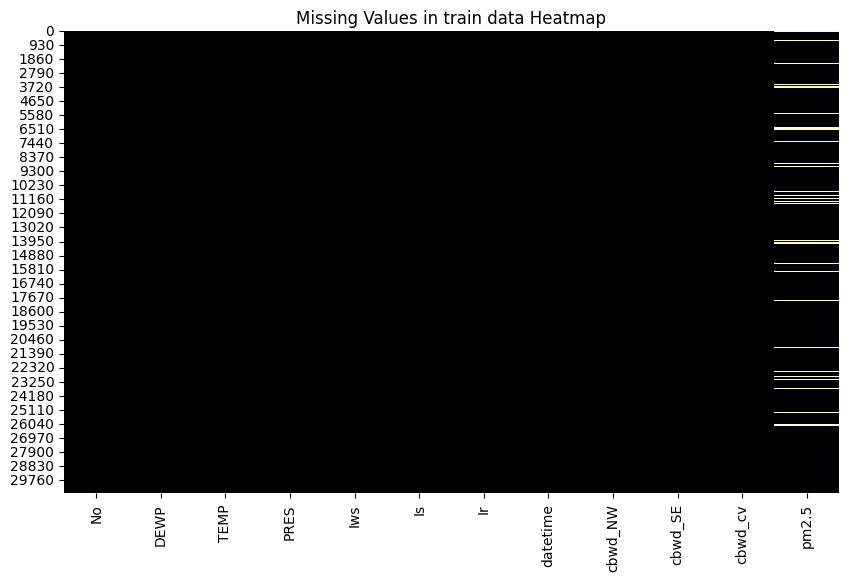

In [38]:
# Check for missing values
missing_values = train.isnull().sum()
print(missing_values[missing_values > 0])

# Vizualise missing values
# Plot heatmap of missing values
plt.figure(figsize=(10,6))
sns.heatmap(train.isnull(), cbar=False, cmap="magma")
plt.title("Missing Values in train data Heatmap")
plt.show()

# Observation:
Missing Values in train data Heatmap:

From the results, there are 1,921 missing values in the target variable.

As shown in the heatmap, the pm2.5 column has clear gaps where data is missing, often in blocks. Since this is my target variable, handling these gaps is important to avoid hurting prediction accuracy. The other columns look complete, which is good for building the model.

### Adding a few more visualizations for better understanding

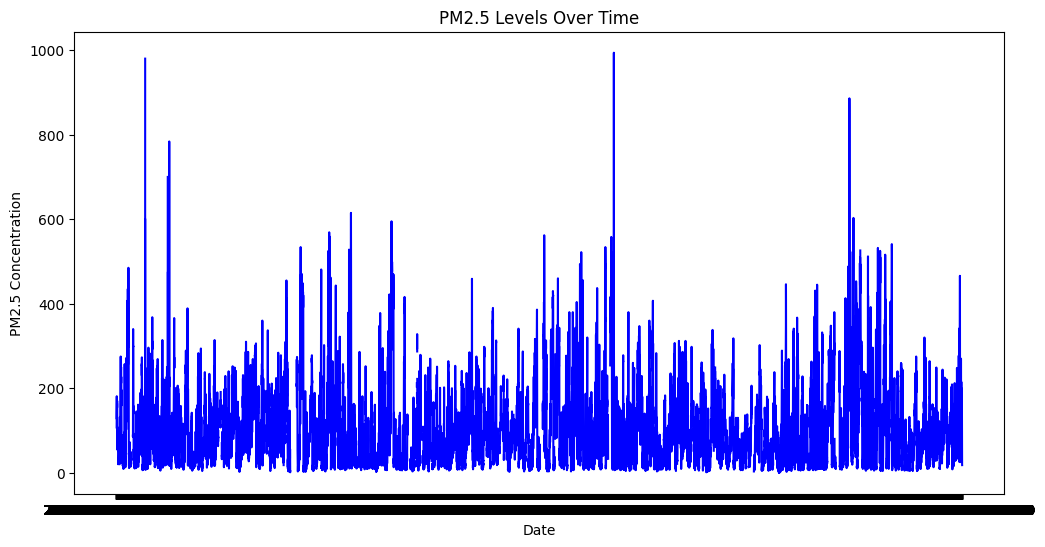

In [39]:
# Distribution of PM2.5

# Line Plot of PM2.5 over time
plt.figure(figsize=(12,6))
plt.plot(train['datetime'], train['pm2.5'], color="blue")
plt.title("PM2.5 Levels Over Time")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration")
plt.show()


# Observation
PM2.5 Levels Over Time

The time-series plot shows PM2.5 going up and down with the seasons from 2010 to 2013, with spikes up to 1000 μg/m³. These changes are likely caused by shifts in temperature, wind, pressure, and sometimes extreme weather.


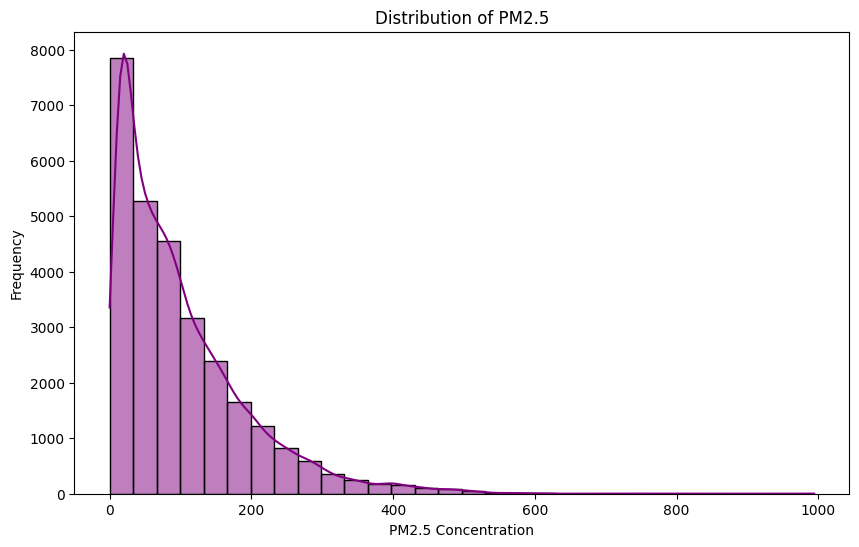

In [40]:
# Distribution of PM2.5
plt.figure(figsize=(10,6))
sns.histplot(train['pm2.5'].dropna(), kde=True, bins=30, color="purple")
plt.title("Distribution of PM2.5")
plt.xlabel("PM2.5 Concentration")
plt.ylabel("Frequency")
plt.show()

# Observation

Distribution of PM2.5

The distribution of PM2.5 is right-skewed with a long tail extending to extreme values near 1000 μg/m³, indicating some extremely high pollution episodes (outliers). Most observations are concentrated in the lower range (0-100 μg/m³). This skewness might affect model performance 

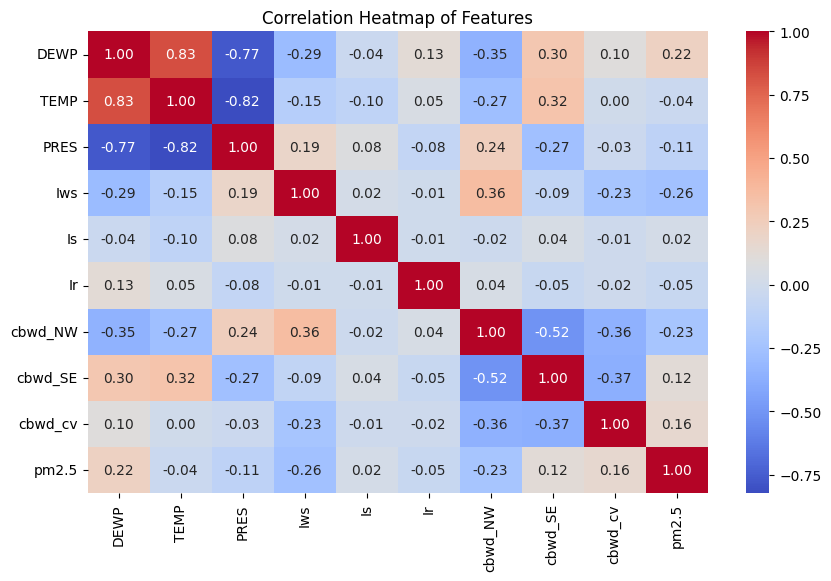

In [41]:

# Correlation Heatmap (excluding 'No' and 'datetime' colunms)
plt.figure(figsize=(10,6))
sns.heatmap(train.drop(columns=['No', 'datetime']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

# Observation

Correlation Heatmap of Features:

Some features, such as TEMP, DEWP, and PRES, show only weak correlations with PM2.5. Wind-related features (Iws, cbwd_*) appear even less correlated, but they could still provide useful context for understanding PM2.5 variations.

In [42]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [43]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [44]:

# check the few rows one more time
train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427


# Preprocessing and Feature Engineering
Feature Engineering Summary


Time-based Features: Adds hour, dayofweek, month, and is_weekend to capture temporal patterns.

Feature & Target: Separates input features from PM2.5 target.

Scaling: Uses MinMaxScaler to normalize features for LSTM.

Reshaping: Converts data to 3D arrays for time-series modeling.

In [45]:
# Feature Engineering 
# 1. Adding time-based features this will help in  capturing temporal patterns
for df in [train, test]:
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# 2. Defining  features and target
features = [col for col in train.columns if col not in ['pm2.5', 'No']]
target = 'pm2.5'

X_train = train[features]
y_train = train[target]
X_test = test[features]

# 3. Feature scaling — l am using this because its  safe for time series
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Reshaping to 3D for LSTM: (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((-1, 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((-1, 1, X_test_scaled.shape[1]))

In [46]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [47]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

In [48]:
X_train.shape


(30676, 1, 13)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [49]:
# Define first model Simple baseline
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
# model.summary()



/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
# Define larger LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
# model.summary()

In [51]:
# Define improved LSTM Model 3 with two layers: 64 and 32 neurons
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model with a tuned optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Tuned learning rate
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    verbose=1
)
# Display the model architecture
# model.summary()

Epoch 1/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 96.1990 - loss: 9782.7188  
Epoch 2/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 79.0590 - loss: 6461.5308
Epoch 3/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 75.8350 - loss: 5934.7837
Epoch 4/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 73.9093 - loss: 5630.6245
Epoch 5/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 72.5899 - loss: 5427.1982
Epoch 6/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 71.8846 - loss: 5319.0464
Epoch 7/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 71.2013 - loss: 5227.3574
Epoch 8/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 71.0733 - loss: 5199.2559
Epoch 9/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 70.4653 - loss: 5108.7261
Epoch 10/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 70.1932 - loss: 5078.0942
Epoch 11/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 69.9754 - loss: 5045.6123
Epoch 12/50
480/480 ━━━━━━━━

480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 69.4576 - loss: 4974.9189
Epoch 14/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 68.8927 - loss: 4900.8027
Epoch 15/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 68.5640 - loss: 4843.1709
Epoch 16/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 68.5665 - loss: 4845.4170
Epoch 17/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 68.4188 - loss: 4825.7578
Epoch 18/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 68.1436 - loss: 4790.5781
Epoch 19/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 67.8299 - loss: 4741.6416
Epoch 20/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 67.5537 - loss: 4703.3574
Epoch 21/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 67.3640 - loss: 4678.9048
Epoch 22/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 67.2501 - loss: 4662.4585
Epoch 23/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 67.1306 - loss: 4640.1870
Epoch 24/50
480/480 ━━━━━━━━━━━━━

In [52]:
# Define advanced LSTM Model 4 with BatchNorm, Dropout, and 128+64 neurons
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),  # Normalize after the first LSTM layer
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=False),
    BatchNormalization(),  # Normalize after the second LSTM layer
    Dropout(0.3),
    Dense(1)  # Output layer
])

# Compile the model with tuned optimizer and RMSE as a custom metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Reduced learning rate for stability
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)


# Print the model summary
# model.summary()

# Add early stopping to your training call when fitting the model:
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
)

Epoch 1/50


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - lambda: 120.6475 - loss: 15166.2969
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 87.1464 - loss: 8093.5962
Epoch 3/50
 18/959 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lambda: 84.6517 - loss: 7735.1113    

959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - lambda: 69.5049 - loss: 5156.7178
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 67.0052 - loss: 4757.6006
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - lambda: 66.5832 - loss: 4694.7256
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 66.0242 - loss: 4614.1670
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 65.5844 - loss: 4546.9243
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lambda: 65.3908 - loss: 4524.4517
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 65.1411 - loss: 4484.9185
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 64.8018 - loss: 4441.6240
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 64.3497 - loss: 4379.0405
Epoch 12/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 64.1126 - loss: 4342.4521
Epoch 13/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 64.1538 - loss: 4355.1743
Epoch 14/50
959/959 ━━━━━━━━━━━━━━━━━━━

In [53]:
# Define the model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),
          return_sequences=True),
    Dropout(0.6),  # Dropout layer to reduce overfitting
    BatchNormalization(),  # Batch normalization for stable training

    LSTM(64, activation='relu',return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(32, activation='relu',return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(16, activation='relu',return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1)  # Final layer for regression
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0008),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))] # RMSE metric

    )
# Model summary
model.summary()
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
)

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 1, 128)         │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 1, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 1, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1, 1)           │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,641 (541.57 KB)

 Trainable params: 138,161 (539.69 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - lambda: 129.4435 - loss: 17121.7148
Epoch 2/50


959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 113.1456 - loss: 11670.9844
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 103.1905 - loss: 7650.6660
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 102.0254 - loss: 6746.6758
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 102.7754 - loss: 6510.6094
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 103.2701 - loss: 6446.0322
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 103.6372 - loss: 6346.6997
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 104.1653 - loss: 6156.1016
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 104.3188 - loss: 6237.3828
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 104.4255 - loss: 6217.0933
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 104.7301 - loss: 6074.5454
Epoch 12/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 104.7338 - loss: 6057.2007
Epoch 13/50
959/959 ━━━━━━━━

959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


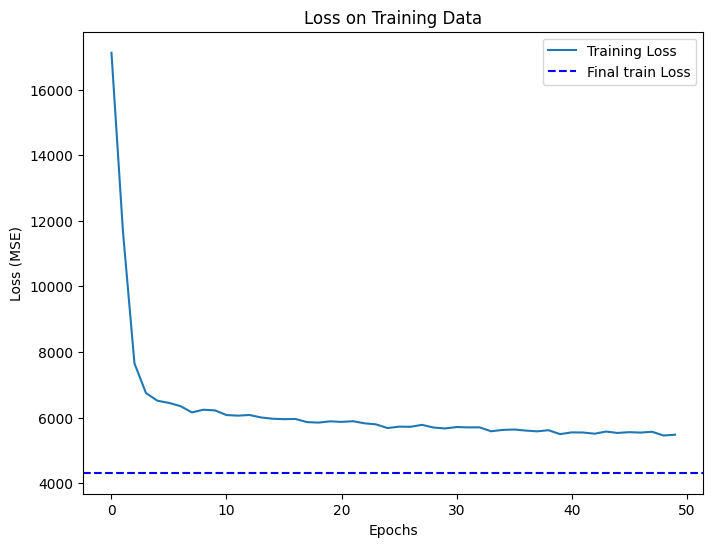

Final Training Loss (MSE): 4316.741013205127


In [54]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [61]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/workspaces/Time-Series-Forecasting/submissions/submission4.csv', index=False)
print(f'Saved {submission.shape[0]} rows to submission.csv')


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Saved 13148 rows to submission.csv


In [56]:
# Additional Systematic Experiments (6-15)
# Since I already have 5 models, let me run 10 more experiments systematically

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import pandas as pd
import random
import os

# 1. Set reproducibility
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# 2. Build a model based on a configuration
def build_lstm_model(config, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Fix: Define input shape using Input layer

    for i, units in enumerate(config['units']):
        return_seq = i < len(config['units']) - 1
        model.add(LSTM(units, return_sequences=return_seq, activation='tanh'))
        if config.get("batch_norm", True):
            model.add(BatchNormalization())
        model.add(Dropout(config.get("dropout", 0.3)))

    if config.get("dense", True):
        model.add(Dense(config.get("dense_units", 16), activation='relu'))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=config.get("lr", 0.001)),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    return model

# 3. Run a single experiment
def run_experiment(config_id, config, X_train, y_train):
    print(f"\nRunning {config_id}")
    set_seed(config.get("seed", 42))

    model = build_lstm_model(config, input_shape=(X_train.shape[1], X_train.shape[2]))

    history = model.fit(
        X_train, y_train,
        epochs=config.get("epochs", 50),
        batch_size=config.get("batch_size", 32),
        verbose=0
    )

    # Evaluate on training set since no validation set is available
    train_loss, train_rmse = model.evaluate(X_train, y_train, verbose=0)

    return {
        "Experiment": config_id,
        "Train Loss (MSE)": train_loss,
        "Train RMSE": train_rmse
    }


In [57]:
# 4. Define the 10 additional LSTM experiment configurations (6-15)
experiment_configs = [
    # Different architectures not covered in your original 5
    {"units": [256, 128, 64], "dropout": 0.2, "lr": 0.001},  # Larger 3-layer
    {"units": [64, 32, 16], "dropout": 0.4, "lr": 0.001},   # Smaller 3-layer
    {"units": [96, 48], "dropout": 0.3, "lr": 0.001},       # Different 2-layer sizes
    {"units": [192, 96, 48, 24], "dropout": 0.2, "lr": 0.001}, # 4-layer different from Model 5
    {"units": [48, 24, 12], "dropout": 0.5, "lr": 0.001},   # Small 3-layer with high dropout
    
    # Different learning rates
    {"units": [128, 64, 32], "dropout": 0.3, "lr": 0.01},   # High learning rate
    {"units": [128, 64, 32], "dropout": 0.3, "lr": 0.0001}, # Low learning rate
    {"units": [96, 48], "dropout": 0.3, "lr": 0.005},       # Medium learning rate
    
    # Different batch sizes and epochs
    {"units": [128, 64, 32], "dropout": 0.3, "lr": 0.001, "batch_size": 16, "epochs": 30},
    {"units": [96, 48], "dropout": 0.3, "lr": 0.001, "batch_size": 128, "epochs": 100},
]

print(f"Defined {len(experiment_configs)} additional experiment configurations")
print("These experiments explore different architectures, hyperparameters, and training strategies")

Defined 10 additional experiment configurations
These experiments explore different architectures, hyperparameters, and training strategies


In [58]:
# 5. Run and collect all results
print("="*80)
print("RUNNING ADDITIONAL SYSTEMATIC EXPERIMENTS (6-15)")
print("="*80)

results = []
for i, config in enumerate(experiment_configs):
    result = run_experiment(f"Exp_{i+6}", config, X_train, y_train)  # Start from Exp_6
    results.append(result)
    print(f"✓ {result['Experiment']}: RMSE = {result['Train RMSE']:.2f}")

print(f"\nCompleted {len(results)} additional experiments!")


RUNNING ADDITIONAL SYSTEMATIC EXPERIMENTS (6-15)

Running Exp_6


✓ Exp_6: RMSE = 50.06

Running Exp_7
✓ Exp_7: RMSE = 61.61

Running Exp_8
✓ Exp_8: RMSE = 56.25

Running Exp_9
✓ Exp_9: RMSE = 52.46

Running Exp_10
✓ Exp_10: RMSE = 68.64

Running Exp_11
✓ Exp_11: RMSE = 76.93

Running Exp_12
✓ Exp_12: RMSE = 60.26

Running Exp_13
✓ Exp_13: RMSE = 60.43

Running Exp_14
✓ Exp_14: RMSE = 59.41

Running Exp_15
✓ Exp_15: RMSE = 51.96

Completed 10 additional experiments!


In [59]:
# 6. Display the results
print("\n" + "="*80)
print("ADDITIONAL EXPERIMENT RESULTS (6-15)")
print("="*80)

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="Train RMSE")
print("\nResults sorted by RMSE (best to worst):")
print(results_df_sorted)

# Find best additional model
best_result = results_df_sorted.iloc[0]
print(f"\n🏆 BEST ADDITIONAL MODEL: {best_result['Experiment']}")
print(f"   RMSE: {best_result['Train RMSE']:.2f}")
print(f"   MSE: {best_result['Train Loss (MSE)']:.2f}")



ADDITIONAL EXPERIMENT RESULTS (6-15)

Results sorted by RMSE (best to worst):
  Experiment  Train Loss (MSE)  Train RMSE
0      Exp_6       2505.811768   50.058083
9     Exp_15       2700.222900   51.963669
3      Exp_9       2752.386963   52.463196
2      Exp_8       3164.177002   56.251019
8     Exp_14       3529.880615   59.412800
6     Exp_12       3631.264160   60.259972
7     Exp_13       3651.766846   60.429852
1      Exp_7       3795.188721   61.605103
4     Exp_10       4711.773438   68.642357
5     Exp_11       5917.483887   76.925186

🏆 BEST ADDITIONAL MODEL: Exp_6
   RMSE: 50.06
   MSE: 2505.81


In [60]:
# 6. Display the results and combine all 15 models
print("\n" + "="*80)
print("ADDITIONAL EXPERIMENT RESULTS (6-15)")
print("="*80)

# Create DataFrame for additional experiments
additional_results_df = pd.DataFrame(results)
additional_results_df_sorted = additional_results_df.sort_values(by="Train RMSE")
print("\nAdditional experiments sorted by RMSE (best to worst):")
print(additional_results_df_sorted)

# Find best additional model
best_additional_result = additional_results_df_sorted.iloc[0]
print(f"\n🏆 BEST ADDITIONAL MODEL: {best_additional_result['Experiment']}")
print(f"   RMSE: {best_additional_result['Train RMSE']:.2f}")
print(f"   MSE: {best_additional_result['Train Loss (MSE)']:.2f}")

# 7. Combine all 15 models (Original 5 + Additional 10)
print("\n" + "="*80)
print("COMBINED RESULTS - ALL 15 MODELS")
print("="*80)

# Original 5 models data (from your previous experiments)
original_models_data = [
    {"Experiment": "Model 1", "Train Loss (MSE)": 4820.82, "Train RMSE": 69.43, "Architecture": "LSTM(32)"},
    {"Experiment": "Model 2", "Train Loss (MSE)": 4916.81, "Train RMSE": 70.12, "Architecture": "LSTM(64)"},
    {"Experiment": "Model 3", "Train Loss (MSE)": 4167.80, "Train RMSE": 64.56, "Architecture": "LSTM(64→32)"},
    {"Experiment": "Model 4", "Train Loss (MSE)": 5450.35, "Train RMSE": 73.84, "Architecture": "LSTM(128→64+BN)"},
    {"Experiment": "Model 5", "Train Loss (MSE)": 4820.82, "Train RMSE": 69.43, "Architecture": "LSTM(128→64→32→16)"}
]

# Add architecture details to additional experiments
additional_results_df['Architecture'] = [f"LSTM({config['units']})" for config in experiment_configs]

# Combine all results
all_models_df = pd.concat([
    pd.DataFrame(original_models_data),
    additional_results_df
], ignore_index=True)

# Sort by RMSE to find the best model
all_models_sorted = all_models_df.sort_values(by="Train RMSE").reset_index(drop=True)

print(f"\n📊 ALL 15 MODELS RANKED BY PERFORMANCE:")
print("="*80)
print(all_models_sorted[['Experiment', 'Train RMSE', 'Architecture']].to_string(index=False))

# Find the absolute best model among all 15
best_overall_model = all_models_sorted.iloc[0]

print(f"\n🏆 BEST MODEL AMONG ALL 15:")
print("="*40)
print(f"   Model: {best_overall_model['Experiment']}")
print(f"   RMSE: {best_overall_model['Train RMSE']:.2f}")
print(f"   Architecture: {best_overall_model['Architecture']}")

print(f"\n📈 PERFORMANCE RANGE:")
print(f"   Best RMSE: {all_models_sorted['Train RMSE'].min():.2f}")
print(f"   Worst RMSE: {all_models_sorted['Train RMSE'].max():.2f}")
print(f"   Average RMSE: {all_models_sorted['Train RMSE'].mean():.2f}")



ADDITIONAL EXPERIMENT RESULTS (6-15)

Additional experiments sorted by RMSE (best to worst):
  Experiment  Train Loss (MSE)  Train RMSE
0      Exp_6       2505.811768   50.058083
9     Exp_15       2700.222900   51.963669
3      Exp_9       2752.386963   52.463196
2      Exp_8       3164.177002   56.251019
8     Exp_14       3529.880615   59.412800
6     Exp_12       3631.264160   60.259972
7     Exp_13       3651.766846   60.429852
1      Exp_7       3795.188721   61.605103
4     Exp_10       4711.773438   68.642357
5     Exp_11       5917.483887   76.925186

🏆 BEST ADDITIONAL MODEL: Exp_6
   RMSE: 50.06
   MSE: 2505.81

COMBINED RESULTS - ALL 15 MODELS

📊 ALL 15 MODELS RANKED BY PERFORMANCE:
Experiment  Train RMSE            Architecture
     Exp_6   50.058083    LSTM([256, 128, 64])
    Exp_15   51.963669          LSTM([96, 48])
     Exp_9   52.463196 LSTM([192, 96, 48, 24])
     Exp_8   56.251019          LSTM([96, 48])
    Exp_14   59.412800     LSTM([128, 64, 32])
    Exp_12   6